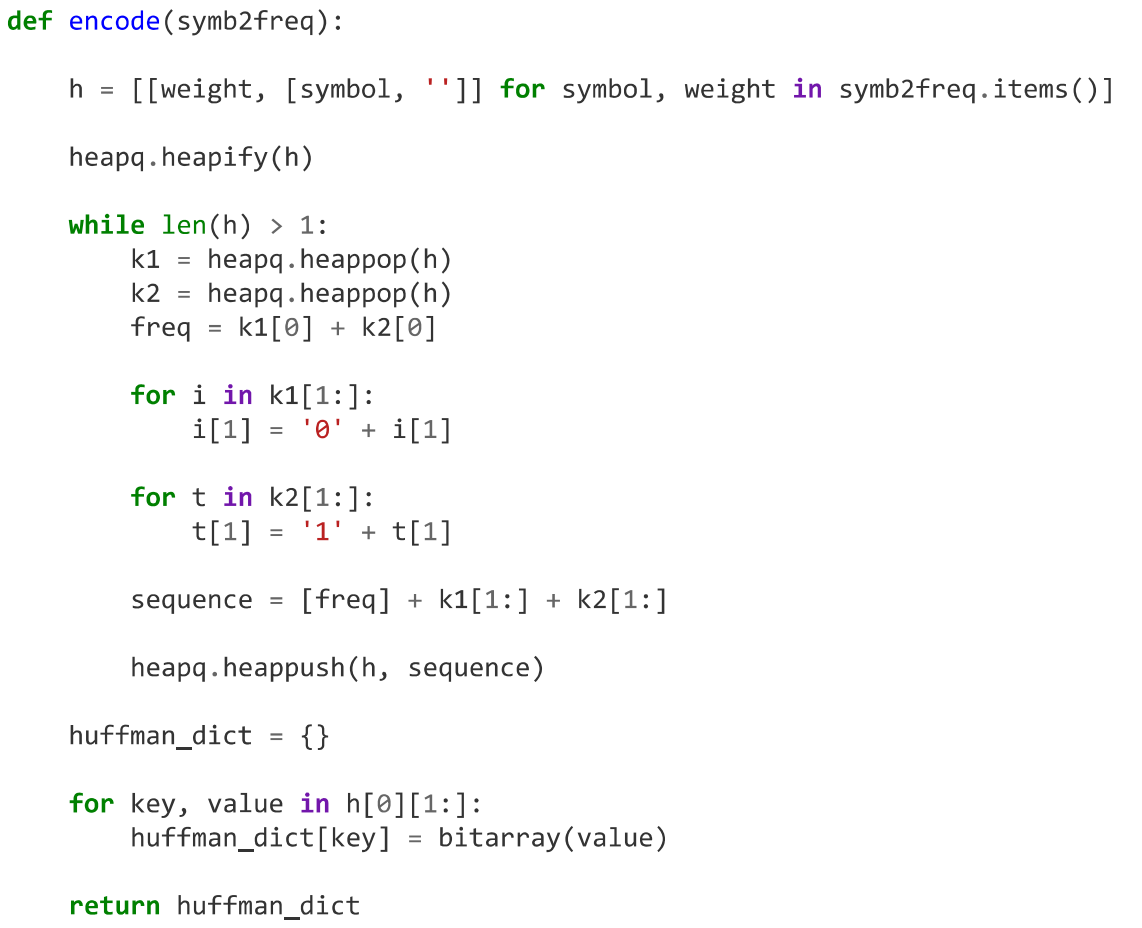

In [ ]:
import heapq
from urllib.request import urlopen
import shutil
import gzip
import os
from collections import defaultdict
from bitarray import bitarray
import pickle


# Download the file if need be:
def download_file(url, filename):
    if not os.path.exists(filename):
        response = urlopen(url + filename)
        shutil.copyfileobj(
            gzip.GzipFile(fileobj=response), open(filename, 'wb'))


# build a frequency table:
def build_freq(filename):
    freq = defaultdict(int)
    with open(filename, 'rb') as f:
        for line in f:
            for char in line:
                freq[char] += 1
    total = float(sum(freq.values()))
    return {char: count / total for (char, count) in freq.items()}


# Now build the Huffman encoding:
def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights.
    Accept a dictionary which maps a symbol to a probability.
    Return a new dictionary which maps a symbol to a bitarray."""

    h = [[weight, [symbol, ""]] for symbol, weight in symb2freq.items()]
    
    #Heapify to get sorted
    heapq.heapify(h)
    
    #For every symbol, greedily assign code
    while len(h):
        m1 = m2 = heapq.heappop(h)
        freq = m1[0]+m2[0]
        
        for i in m1[1:]:
            i[1] = "0" + i[1]
        
        for j in m2[1:]:
            j[1] = "1" + j[1]
            
        seq = [freq] + m1[1:] + m2[1:]
        
        heapq.heappush(h, seq)
    
    #Store calculated symbol+encodings pairs in dictionary
    huffman_dictionary = {}
    for key, value in h[0][1:]:
        huffman_dictionary = bitarray(value)
        
    return huffman_dictionary


# Now compress the file:
def compress(filename, encoding, compressed_name=None):
    if compressed_name is None:
        compressed_name = filename + ".huff"
    output = bitarray()
    with open(filename, 'rb') as f:
        for line in f:
            for char in line:
                output.extend(encoding[char])
    N = len(output)
    with open(compressed_name, 'wb') as f:
        pickle.dump(N, f)
        pickle.dump(encoding, f)
        output.tofile(f)


# Now decompress the file:
def decompress(filename, decompressed_name=None):
    if decompressed_name is None:
        decompressed_name = filename + ".dehuff"
    with open(filename, 'rb') as f:
        N = pickle.load(f)
        encoding = pickle.load(f)
        bits = bitarray()
        bits.fromfile(f)
        bits = bits[:N]

    # Totally cheating here and using a builtin method:
    output = bits.decode(encoding)
    with open(decompressed_name, 'wb') as f:
        f.write(bytes(output))


url = "http://www.gutenberg.org/ebooks/"
filename = "100.txt.utf-8"

download_file(url, filename)
freq = build_freq(filename)
encoding = encode(freq)
compress(filename, encoding)
decompress(filename + ".huff")
# Do you get identical files?